# Allocate Benchmarks

In [1]:
# select measurement file
file_name = "../output/2024-08-25 19-34-06 full.json"

# select style options
grey_fill_between = False

enable_storage_reference = True

if grey_fill_between:
    fill_between_args = {"color": "grey"}
else:
    fill_between_args = {}


In [2]:
# parse data
import json

with open(file_name) as file:
    raw_data = json.load(file)

In [3]:
from util.convert import convert_data
from IPython.core.display import HTML

# filter and convert data
allocate_min = convert_data(raw_data, "allocate_min", ["mean", "min", "max", "options.object_size", "machine_name", "cold_start", "repetitions"])
allocate_max = convert_data(raw_data, "allocate_max", ["mean", "min", "max", "options.object_size", "machine_name", "cold_start", "repetitions"])
allocate_case1 = convert_data(raw_data, "allocate_case_1", ["mean", "min", "max", "options.object_size", "machine_name", "cold_start", "repetitions"])

display(HTML("<b>MIN Data:</b>"))
display(allocate_min.head())
display(HTML("<b>MAX Data:</b>"))
display(allocate_max.head())
display(HTML("<b>Case 1 Data:</b>"))
display(allocate_case1.head())

,mean,min,max,options.object_size,machine_name,cold_start,repetitions,ticks_per_ms
0,5522.0,5522,5522,0,esp32c3,100,1000,16000
1,5562.0,5562,5562,32,esp32c3,100,1000,16000
2,5588.0,5588,5588,64,esp32c3,100,1000,16000
3,5615.0,5615,5615,96,esp32c3,100,1000,16000
4,5642.0,5642,5642,128,esp32c3,100,1000,16000


,mean,min,max,options.object_size,machine_name,cold_start,repetitions,ticks_per_ms
0,372093.0,372093,372093,0,esp32c3,100,1000,16000
1,304178.0,304178,304178,32,esp32c3,100,1000,16000
2,288179.0,288179,288179,64,esp32c3,100,1000,16000
3,308966.0,308966,308966,96,esp32c3,100,1000,16000
4,336177.0,336177,336177,128,esp32c3,100,1000,16000


,mean,min,max,options.object_size,machine_name,cold_start,repetitions,ticks_per_ms
0,325676.0,325676,325676,0,esp32c3,100,1000,16000
1,229701.0,229701,229701,32,esp32c3,100,1000,16000
2,197723.0,197723,197723,64,esp32c3,100,1000,16000
3,165742.0,165742,165742,96,esp32c3,100,1000,16000
4,165762.0,165762,165762,128,esp32c3,100,1000,16000


In [4]:
from util.convert import get_storage_measurement
from IPython.core.display import HTML

(storage_read, storage_write) = get_storage_measurement(raw_data, allocate_max["options.object_size"].max())

display(HTML("<b>READ Data:</b>"))
display(storage_read.head())
display(HTML("<b>WRITE Data:</b>"))
display(storage_write.head())

,mean,min,max,options.object_size,machine_name,cold_start,repetitions,ticks_per_ms
0,2636.0,2636,2636,0,esp32c3,100,1000,16000
1,23509.0,23509,23509,32,esp32c3,100,1000,16000
2,48339.0,48339,48339,64,esp32c3,100,1000,16000
3,69211.0,69211,69211,96,esp32c3,100,1000,16000
4,96340.0,96340,96340,128,esp32c3,100,1000,16000


,mean,min,max,options.object_size,machine_name,cold_start,repetitions,ticks_per_ms
0,3908.0,3908,3908,0,esp32c3,100,1000,16000
1,31994.0,31994,31994,32,esp32c3,100,1000,16000
2,48177.0,48177,48177,64,esp32c3,100,1000,16000
3,68964.0,68964,68964,96,esp32c3,100,1000,16000
4,96177.0,96177,96177,128,esp32c3,100,1000,16000


# Final Plot

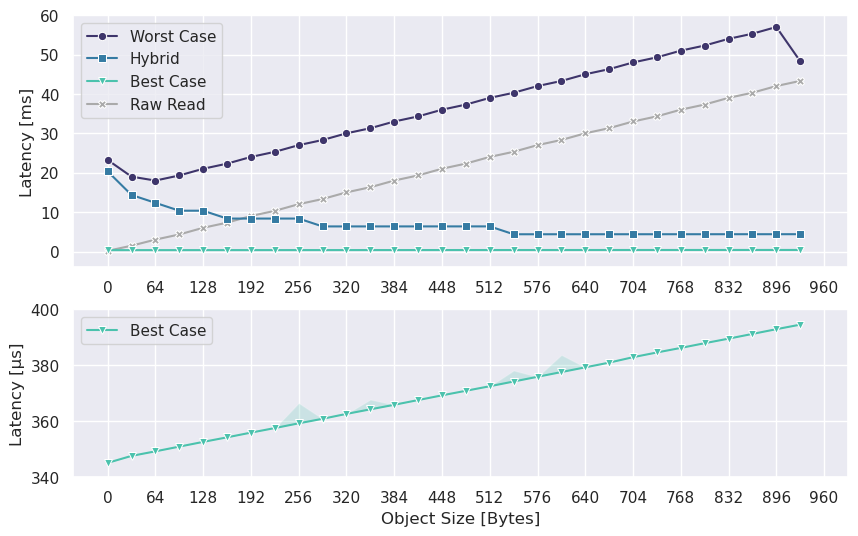

In [7]:
from util.plot import set_gird, save_plot, set_theme
from util.convert import scale_data
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import gridspec

set_theme()
fig = plt.figure(1)
fig.set_figheight(6)
fig.set_figwidth(10)

gs = gridspec.GridSpec(nrows=2, ncols=1, height_ratios=[1.5, 1]) 
ax = plt.subplot(gs[0])

unit = "ms"

if enable_storage_reference and len(storage_read) != 0:
    storage_read_scaled = scale_data(storage_read, unit)
    sns.lineplot(ax=ax, x=storage_read_scaled["options.object_size"], y=storage_read_scaled["mean"], label="Raw Read", markers=["o"], marker="X", color="#aaaaaa")

if len(allocate_max) != 0:
    allocate_max_scaled = scale_data(allocate_max, unit)
    sns.lineplot(ax=ax, x=allocate_max_scaled["options.object_size"], y=allocate_max_scaled["mean"], label="Worst Case", markers=["o"], marker="o")
    ax.fill_between(allocate_max_scaled["options.object_size"], allocate_max_scaled["min"], allocate_max_scaled["max"], alpha=0.2, **fill_between_args)

if len(allocate_case1) != 0:
    allocate_case1_scaled = scale_data(allocate_case1, unit)
    sns.lineplot(ax=ax, x=allocate_case1_scaled["options.object_size"], y=allocate_case1_scaled["mean"], label="Hybrid", markers=["o"], marker="s")
    ax.fill_between(allocate_case1_scaled["options.object_size"], allocate_case1_scaled["min"], allocate_case1_scaled["max"], alpha=0.2, **fill_between_args)

if len(allocate_min) != 0:
    allocate_min_scaled = scale_data(allocate_min, unit)
    sns.lineplot(ax=ax, x=allocate_min_scaled["options.object_size"], y=allocate_min_scaled["mean"], label="Best Case", markers=["o"], marker="v")
    ax.fill_between(allocate_min_scaled["options.object_size"], allocate_min_scaled["min"], allocate_min_scaled["max"], alpha=0.2, **fill_between_args)

set_gird(64, max(allocate_min["options.object_size"].max(), allocate_max["options.object_size"].max()), ax)

ax.set_xlabel(None)
ax.set_ylabel(f"Latency [{unit}]")
#plt.axis([200, 300, 10000, 15000])
ax.set_ylim(bottom=-4, top=60)

if enable_storage_reference:
    handles, labels = plt.gca().get_legend_handles_labels()
    handles.append(handles.pop(0))
    labels.append(labels.pop(0))
    plt.legend(handles, labels) 

set_theme(3, 2)
ax = plt.subplot(gs[1])

unit = "µs"

# if len(allocate_max) != 0:
#     allocate_max_scaled = scale_data(allocate_max, unit)
#     sns.lineplot(ax=ax, x=allocate_max_scaled["options.object_size"], y=allocate_max_scaled["mean"], label="Worst Case", markers=["o"], marker="o")
#     ax.fill_between(allocate_max_scaled["options.object_size"], allocate_max_scaled["min"], allocate_max_scaled["max"], alpha=0.2, **fill_between_args)

#if len(allocate_case1) != 0:
#    allocate_case1_scaled = scale_data(allocate_case1, unit)
#    sns.lineplot(ax=ax, x=allocate_case1_scaled["options.object_size"], y=allocate_case1_scaled["mean"], label="Additional Example", markers=["o"], marker="s")
#    ax.fill_between(allocate_case1_scaled["options.object_size"], allocate_case1_scaled["min"], allocate_case1_scaled["max"], alpha=0.2, **fill_between_args)

if len(allocate_min) != 0:
    allocate_min_scaled = scale_data(allocate_min, unit)
    sns.lineplot(ax=ax, x=allocate_min_scaled["options.object_size"], y=allocate_min_scaled["mean"], label="Best Case", markers=["o"], marker="v")
    ax.fill_between(allocate_min_scaled["options.object_size"], allocate_min_scaled["min"], allocate_min_scaled["max"], alpha=0.2, **fill_between_args)

set_gird(64, max(allocate_min["options.object_size"].max(), allocate_max["options.object_size"].max()), ax)

ax.set_xlabel("Object Size [Bytes]")
ax.set_ylabel(f"Latency [{unit}]")
#plt.axis([200, 300, 10000, 15000])
ax.set_ylim(bottom=340, top=400)

save_plot("allocate")